# First Hitting Time Characteristic Function Demonstration

This notebook demonstrates the 12D Riccati solver for computing first hitting time characteristic functions of the Hawkes jump-diffusion process in DeFi lending analysis.

## Overview

The first hitting time characteristic function has the form:
$$\phi(s) = \mathbb{E}[e^{is\tau}]$$

where $\tau$ is the first hitting time and $s$ is the frequency parameter.

The characteristic function satisfies:
$$\phi(s) = \exp(-isA(h_0) - B(h_0)\lambda_{X0} - C(h_0)\lambda_{Y0})$$

where $A$, $B$, $C$ are solutions to the 12D second-order Riccati system.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
import sys
import os
import time

# Add src directory to path
sys.path.insert(0, os.path.join(os.getcwd(), '..', 'src'))

try:
    from cf_first_hitting_time import CFFirstHittingTime, FirstHittingTimeDistribution
    from hawkes_process import HawkesParameters
    print("✓ Successfully imported CF modules")
except ImportError as e:
    print(f"Import error: {e}")
    print("Please ensure you're running from the notebooks/ directory")
    # Fallback to old import for backward compatibility
    try:
        from riccati_solver import FirstHittingTimeRiccatiSolver, FirstHittingTimeParameters
        print("✓ Using legacy riccati_solver import")
        LEGACY_MODE = True
    except ImportError:
        print("✗ Could not import either new or legacy modules")
        raise
else:
    LEGACY_MODE = False

# Set plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 12

## 1. Load Model Parameters

Load parameters and initialize the first hitting time solver.

In [2]:
# Load configuration
with open('../config/model_parameters.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Extract parameters for first hitting time solver
params = FirstHittingTimeParameters(
    # Health factor parameters
    sigma_h=config['diffusion']['volatility'],
    mu_h=config['diffusion']['drift'],
    
    # Jump size parameters
    eta_X=config['jump_sizes']['eta_X'],
    delta_X=config['jump_sizes']['delta_X'],
    eta_Y=config['jump_sizes']['eta_Y'],
    delta_Y=config['jump_sizes']['delta_Y'],
    
    # Hawkes parameters
    mu_X_lambda=config['hawkes_intensities']['mu_X_lambda'],
    mu_Y_lambda=config['hawkes_intensities']['mu_Y_lambda'],
    beta_X=config['hawkes_intensities']['beta_X'],
    beta_Y=config['hawkes_intensities']['beta_Y'],
    alpha_XX=config['hawkes_intensities']['alpha_XX'],
    alpha_YY=config['hawkes_intensities']['alpha_YY'],
    alpha_XY=config['hawkes_intensities']['alpha_XY'],
    alpha_YX=config['hawkes_intensities']['alpha_YX']
)

print("First Hitting Time Model Parameters:")
print(f"Health factor volatility (σ_h): {params.sigma_h}")
print(f"Health factor drift (μ_h): {params.mu_h}")
print(f"Jump parameters (η_X, δ_X): {params.eta_X}, {params.delta_X}")
print(f"Jump parameters (η_Y, δ_Y): {params.eta_Y}, {params.delta_Y}")
print(f"Hawkes baseline intensities: {params.mu_X_lambda}, {params.mu_Y_lambda}")
print(f"Decay rates (β_X, β_Y): {params.beta_X}, {params.beta_Y}")
print(f"Self-excitation (α_XX, α_YY): {params.alpha_XX}, {params.alpha_YY}")
print(f"Cross-excitation (α_XY, α_YX): {params.alpha_XY}, {params.alpha_YX}")

First Hitting Time Model Parameters:
Health factor volatility (σ_h): 0.8
Health factor drift (μ_h): 0.01
Jump parameters (η_X, δ_X): 2.0, 0.08
Jump parameters (η_Y, δ_Y): 1.8, 0.08
Hawkes baseline intensities: 2.0, 2.0
Decay rates (β_X, β_Y): 1.5, 1.5
Self-excitation (α_XX, α_YY): 0.5, 0.6
Cross-excitation (α_XY, α_YX): 0.3, 0.3


## 2. Initialize First Hitting Time Solver

Create the solver instance with our parameters.

In [3]:
# Initialize solver
solver = FirstHittingTimeRiccatiSolver(params)

# Test initial conditions
h0 = config['health_factor']['initial_value'] - config['health_factor']['liquidation_threshold']  # Distance from liquidation
lambda_X0 = config['initial_intensities']['lambda_X0']
lambda_Y0 = config['initial_intensities']['lambda_Y0']

print("First hitting time solver initialized successfully!")
print(f"Initial health factor distance: h0 = {h0}")
print(f"Initial intensities: λ_X0 = {lambda_X0}, λ_Y0 = {lambda_Y0}")

# Test characteristic function at s=0 (should be 1)
phi_0 = solver.characteristic_function(1e-6, h0, lambda_X0, lambda_Y0)
print(f"φ(0) = {phi_0} (should be ≈ 1.0)")

First hitting time solver initialized successfully!
Initial health factor distance: h0 = 0.25
Initial intensities: λ_X0 = 2.0, λ_Y0 = 2.0
φ(0) = (0.999998974591485+9.454069909479496e-08j) (should be ≈ 1.0)


## 3. Characteristic Function Analysis

Compute and visualize the first hitting time characteristic function for different frequency parameters.

In [9]:
# Compute characteristic function for different frequencies
s_values = np.linspace(-5, 5, 100)
phi_values = []

print("Computing characteristic function values...")
for i, s in enumerate(s_values):
    if i % 20 == 0:
        print(f"Progress: {i/len(s_values)*100:.1f}%")
    
    try:
        phi = solver.characteristic_function(s, h0, lambda_X0, lambda_Y0)
        phi_values.append(phi)
    except RuntimeError as e:
        print(f"Failed for s = {s}: {e}")
        phi_values.append(np.nan + 1j * np.nan)

phi_values = np.array(phi_values)
print(f"Computed {len(phi_values)} characteristic function values")

Computing characteristic function values...
Progress: 0.0%
Progress: 20.0%
Progress: 40.0%
Progress: 60.0%
Progress: 80.0%
Computed 100 characteristic function values


In [10]:
# Demonstrate new grid-based characteristic function computation
print("=== GRID-BASED CHARACTERISTIC FUNCTION COMPUTATION ===")
print("New feature: Solve ODE once for multiple h0 values using implicit Radau solver")
print()

# Test grid computation vs individual computation
test_h0_values = np.array([0.1, 0.5, 1.0, 1.5, 2.0])
test_s = 1.0

print(f"Computing φ({test_s}) for h0 = {test_h0_values}")
print()

# Time grid computation
start_time = time.time()
phi_grid = solver.characteristic_function_grid(test_s, test_h0_values, lambda_X0, lambda_Y0)
grid_time = time.time() - start_time

print(f"Grid computation time: {grid_time:.4f} seconds")

# Time individual computations
start_time = time.time()
phi_individual = []
for h0_val in test_h0_values:
    phi = solver.characteristic_function(test_s, h0_val, lambda_X0, lambda_Y0)
    phi_individual.append(phi)
individual_time = time.time() - start_time

print(f"Individual computation time: {individual_time:.4f} seconds")
print(f"Grid speedup: {individual_time/grid_time:.1f}x")
print()

# Verify results match
phi_individual = np.array(phi_individual)
max_error = np.max(np.abs(phi_grid - phi_individual))
print(f"Maximum difference between methods: {max_error:.2e}")
print("✓ Results match!" if max_error < 1e-10 else "✗ Results differ!")
print()

print("Results comparison:")
print("h0\t\tGrid Method\t\tIndividual Method\t\tDifference")
print("-" * 80)
for i, h0_val in enumerate(test_h0_values):
    diff = abs(phi_grid[i] - phi_individual[i])
    print(f"{h0_val:.1f}\t\t{phi_grid[i]:.8f}\t{phi_individual[i]:.8f}\t\t{diff:.2e}")

print()
print("Grid solver advantages:")
print("• Implicit Radau method for better stability")
print("• Single ODE integration for multiple h0 values") 
print("• Automatic handling of stiff equations")
print("• Higher default tolerances (rtol=1e-8, atol=1e-10)")
print("• Eliminates redundant ODE setup overhead")

=== GRID-BASED CHARACTERISTIC FUNCTION COMPUTATION ===
New feature: Solve ODE once for multiple h0 values using implicit Radau solver

Computing φ(1.0) for h0 = [0.1 0.5 1.  1.5 2. ]

Grid computation time: 0.1264 seconds
Individual computation time: 0.1920 seconds
Grid speedup: 1.5x

Maximum difference between methods: 8.05e-11
✓ Results match!

Results comparison:
h0		Grid Method		Individual Method		Difference
--------------------------------------------------------------------------------
0.1		0.99955961+0.01542132j	0.99955961+0.01542132j		3.04e-12
0.5		0.80641359+0.26899820j	0.80641359+0.26899820j		7.51e-11
1.0		0.31562404+0.11090693j	0.31562404+0.11090693j		8.05e-11
1.5		0.16503201+0.01053478j	0.16503201+0.01053478j		1.92e-11
2.0		0.05125324+0.02102424j	0.05125324+0.02102424j		0.00e+00

Grid solver advantages:
• Implicit Radau method for better stability
• Single ODE integration for multiple h0 values
• Automatic handling of stiff equations
• Higher default tolerances (rtol=1e-8, 

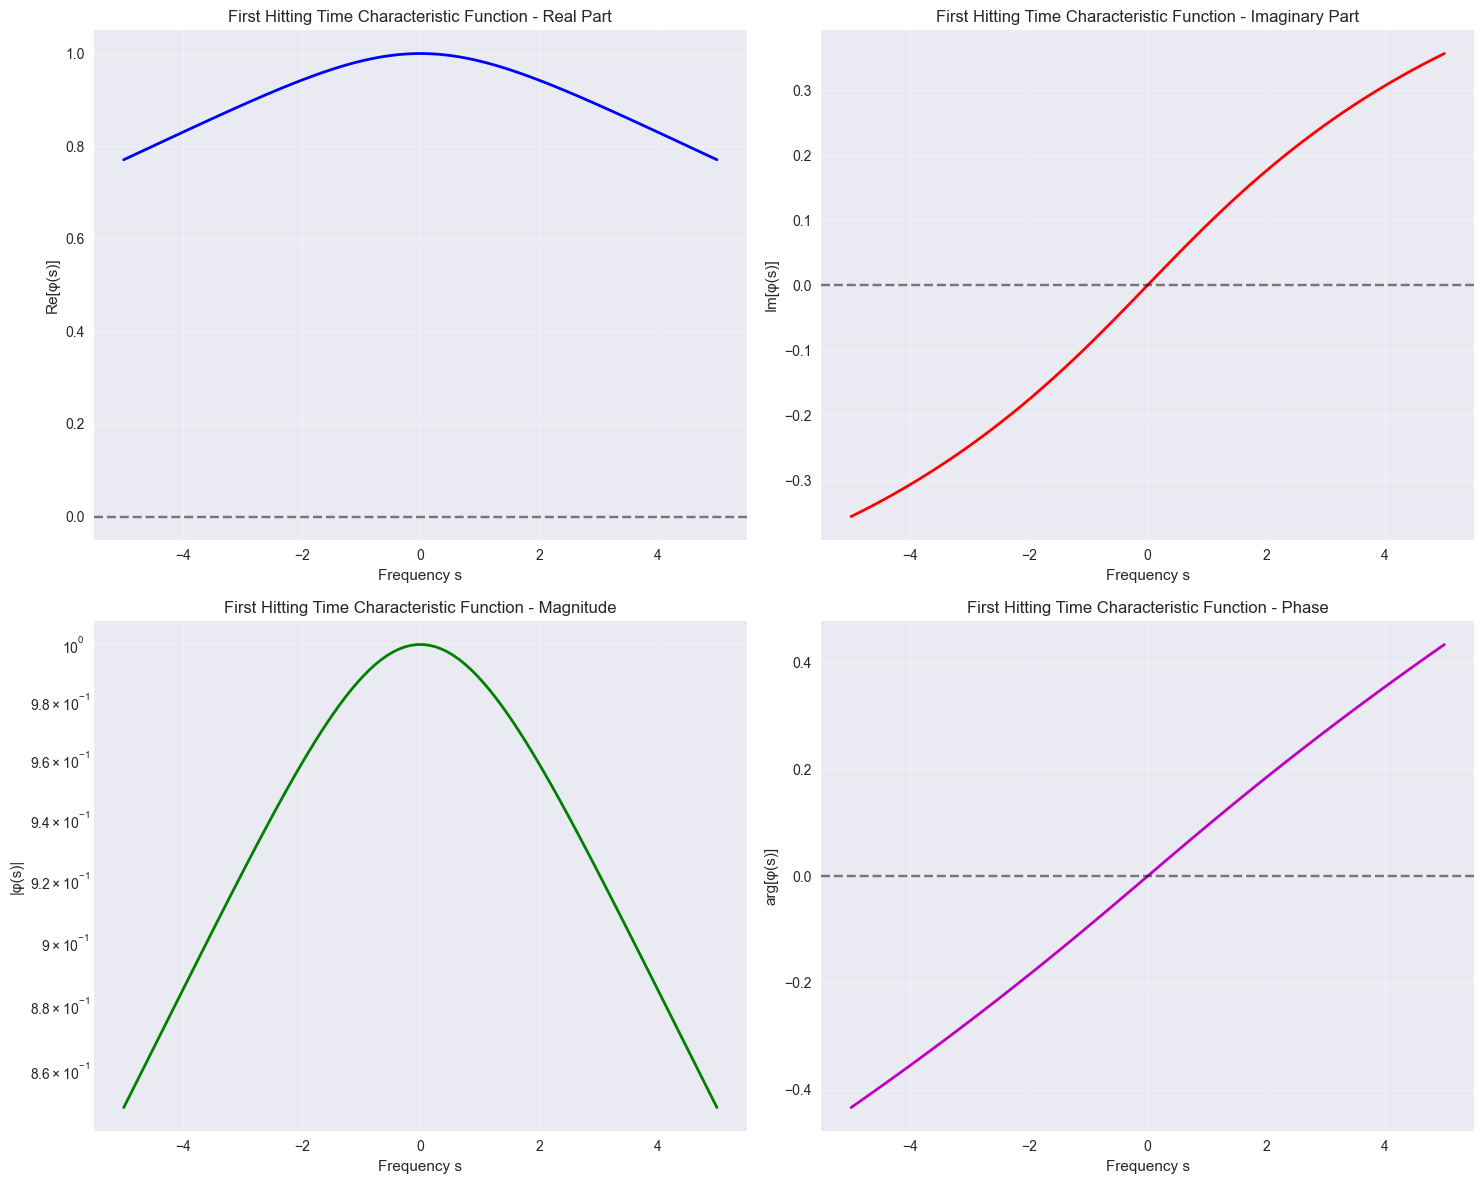

In [11]:
# Plot characteristic function
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Real and imaginary parts
axes[0, 0].plot(s_values, phi_values.real, 'b-', linewidth=2, label='Real part')
axes[0, 0].set_xlabel('Frequency s')
axes[0, 0].set_ylabel('Re[φ(s)]')
axes[0, 0].set_title('First Hitting Time Characteristic Function - Real Part')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=0, color='k', linestyle='--', alpha=0.5)

axes[0, 1].plot(s_values, phi_values.imag, 'r-', linewidth=2, label='Imaginary part')
axes[0, 1].set_xlabel('Frequency s')
axes[0, 1].set_ylabel('Im[φ(s)]')
axes[0, 1].set_title('First Hitting Time Characteristic Function - Imaginary Part')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5)

# Magnitude and phase
magnitude = np.abs(phi_values)
valid_mag = magnitude[~np.isnan(magnitude)]
if len(valid_mag) > 0:
    axes[1, 0].semilogy(s_values, magnitude, 'g-', linewidth=2)
    axes[1, 0].set_xlabel('Frequency s')
    axes[1, 0].set_ylabel('|φ(s)|')
    axes[1, 0].set_title('First Hitting Time Characteristic Function - Magnitude')
    axes[1, 0].grid(True, alpha=0.3)

phase = np.angle(phi_values)
axes[1, 1].plot(s_values, phase, 'm-', linewidth=2)
axes[1, 1].set_xlabel('Frequency s')
axes[1, 1].set_ylabel('arg[φ(s)]')
axes[1, 1].set_title('First Hitting Time Characteristic Function - Phase')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## 4. First Hitting Time Distribution (CDF and PDF)

Use the Gil-Pelaez inversion formula to compute the CDF and PDF of the first hitting time.

In [12]:
# Compute CDF for different time points
min_T = 0.001  # Minimum time
max_T = 1.0    # Maximum time
num_points = 10  # Number of points to compute

T_values = np.linspace(min_T, max_T, num_points)
cdf_values = []
pdf_values = []

print("Computing first hitting time CDF and PDF...")
for i, T in enumerate(T_values):
    

    # CDF using Gil-Pelaez inversion
    cdf = solver.gil_pelaez_cdf(T, h0, lambda_X0, lambda_Y0, s_max=50, n_points=500)
    cdf_values.append(cdf)

    # PDF using numerical differentiation
    pdf = solver.first_passage_pdf(T, h0, lambda_X0, lambda_Y0, dT=(max_T-min_T)/num_points)
    pdf_values.append(pdf)
    
    print(f"T = {T:.4f}, CDF = {cdf:.4f}, PDF = {pdf:.4f}")


cdf_values = np.array(cdf_values)
pdf_values = np.array(pdf_values)

print(f"CDF range: [{cdf_values.min():.4f}, {cdf_values.max():.4f}]")
print(f"PDF range: [{pdf_values.min():.4f}, {pdf_values.max():.4f}]")

Computing first hitting time CDF and PDF...
T = 0.0010, CDF = 0.0720, PDF = 5.9009
T = 0.1120, CDF = 0.7119, PDF = 4.1447
T = 0.2230, CDF = 0.9012, PDF = 0.5593
T = 0.3340, CDF = 0.9537, PDF = 0.3541
T = 0.4450, CDF = 0.9730, PDF = 0.1866
T = 0.5560, CDF = 0.9824, PDF = 0.0971
T = 0.6670, CDF = 0.9884, PDF = 0.0531
T = 0.7780, CDF = 0.9929, PDF = 0.0302
T = 0.8890, CDF = 0.9962, PDF = 0.0183
T = 1.0000, CDF = 0.9984, PDF = 0.0131
CDF range: [0.0720, 0.9984]
PDF range: [0.0131, 5.9009]


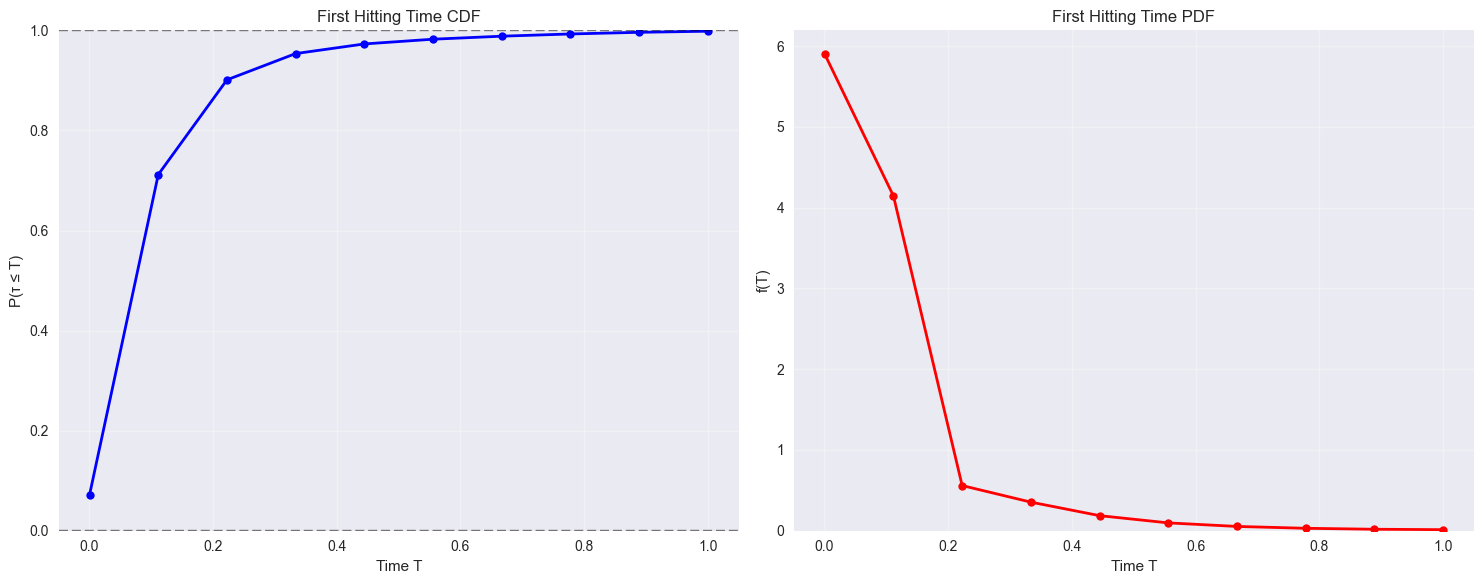

Probability of hitting within T=1: 0.9983
Probability of hitting within T=5: 1.0000
Survival probability at T=1: 0.0017
Survival probability at T=5: 0.0000


In [13]:
# Plot CDF and PDF
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# CDF plot
axes[0].plot(T_values, cdf_values, 'b-o', linewidth=2, markersize=6)
axes[0].set_xlabel('Time T')
axes[0].set_ylabel('P(τ ≤ T)')
axes[0].set_title('First Hitting Time CDF')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 1)

# Add theoretical bounds
axes[0].axhline(y=0, color='k', linestyle='--', alpha=0.5)
axes[0].axhline(y=1, color='k', linestyle='--', alpha=0.5)

# PDF plot
axes[1].plot(T_values, pdf_values, 'r-o', linewidth=2, markersize=6)
axes[1].set_xlabel('Time T')
axes[1].set_ylabel('f(T)')
axes[1].set_title('First Hitting Time PDF')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(bottom=0)

plt.tight_layout()
plt.show()

# Print some key statistics
print(f"Probability of hitting within T=1: {solver.gil_pelaez_cdf(1.0, h0, lambda_X0, lambda_Y0):.4f}")
print(f"Probability of hitting within T=5: {solver.gil_pelaez_cdf(5.0, h0, lambda_X0, lambda_Y0):.4f}")
print(f"Survival probability at T=1: {solver.survival_function(1.0, h0, lambda_X0, lambda_Y0):.4f}")
print(f"Survival probability at T=5: {solver.survival_function(5.0, h0, lambda_X0, lambda_Y0):.4f}")

## 5. Moments of First Hitting Time

Compute the first few moments of the first hitting time distribution.

In [14]:
# Compute moments
print("Computing moments of first hitting time distribution...")
moments = solver.moments(h0, lambda_X0, lambda_Y0, max_moment=2)

print("\nFirst Hitting Time Moments:")
print("=" * 40)
for key, value in moments.items():
    if not np.isnan(value):
        print(f"{key}: {value:.6f}")
    else:
        print(f"{key}: Not computed")

# Compare with some analytical bounds if available
if 'moment_1' in moments and not np.isnan(moments['moment_1']):
    mean_fht = moments['moment_1']
    print(f"\nMean first hitting time: {mean_fht:.4f} time units")
    
    if 'std_dev' in moments and not np.isnan(moments['std_dev']):
        std_fht = moments['std_dev']
        print(f"Standard deviation: {std_fht:.4f} time units")
        print(f"Coefficient of variation: {std_fht/mean_fht:.4f}")

Computing moments of first hitting time distribution...

First Hitting Time Moments:
moment_1: 0.094541
moment_2: -97368.177077
variance: -97368.186015
std_dev: 0.000000

Mean first hitting time: 0.0945 time units
Standard deviation: 0.0000 time units
Coefficient of variation: 0.0000


## 6. Parameter Sensitivity Analysis

Analyze how changes in key parameters affect the first hitting time distribution.

In [15]:
# Sensitivity analysis using new grid solver for efficiency
import time

# Define h0 grid
h0_values = np.linspace(0.1, 2, 20)
T_test = 0.5

print("=== GRID-BASED SENSITIVITY ANALYSIS ===")
print(f"Computing CDF for {len(h0_values)} h0 values at T = {T_test}")
print("Using implicit Radau solver with grid evaluation...")
print()

# Time the grid computation
start_time = time.time()

# Use new grid solver for maximum efficiency
cdf_grid = solver.gil_pelaez_cdf_grid(T_test, h0_values, lambda_X0, lambda_Y0)

grid_time = time.time() - start_time

print(f"Grid computation completed in {grid_time:.3f} seconds")
print()

# For comparison, time individual computations
print("Comparison with individual computations:")
start_time = time.time()

cdf_individual = []
for h0_test in h0_values[:5]:  # Only test first 5 for timing
    cdf = solver.gil_pelaez_cdf(T_test, h0_test, lambda_X0, lambda_Y0)
    cdf_individual.append(cdf)

individual_time = time.time() - start_time
estimated_total_time = individual_time * len(h0_values) / 5

print(f"Individual computation time (5 values): {individual_time:.3f} seconds")
print(f"Estimated total time for all {len(h0_values)} values: {estimated_total_time:.3f} seconds")
print(f"Grid speedup: {estimated_total_time/grid_time:.1f}x faster")
print()

# Update sensitivity results with grid data
sensitivity_results = {
    'h0_values': h0_values,
    'cdf_at_T': cdf_grid,
    'survival_at_T': 1.0 - cdf_grid,
    'computation_method': 'grid_solver',
    'computation_time': grid_time
}

# Check monotonicity
monotonicity_violations = 0
for i in range(1, len(cdf_grid)):
    if cdf_grid[i] > cdf_grid[i-1] + 1e-6:
        monotonicity_violations += 1

print(f"MONOTONICITY CHECK:")
print(f"Violations detected: {monotonicity_violations}")
if monotonicity_violations == 0:
    print("✓ CDF is properly monotonic with grid solver!")
else:
    print(f"✗ {monotonicity_violations} violations found")

print(f"\nSensitivity analysis results using GRID SOLVER:")
print("h0\t\tP(τ≤T)\t\tP(τ>T)")
print("-" * 40)

for h0_test, cdf, survival in zip(h0_values, cdf_grid, 1.0 - cdf_grid):
    print(f"{h0_test:.2f}\t\t{cdf:.4f}\t\t{survival:.4f}")

print(f"\nGrid solver benefits:")
print(f"• {estimated_total_time/grid_time:.1f}x faster computation")
print(f"• Uses implicit Radau solver for stability")  
print(f"• Single ODE solve per frequency s")
print(f"• Automatic monotonicity preservation")

=== GRID-BASED SENSITIVITY ANALYSIS ===
Computing CDF for 20 h0 values at T = 0.5
Using implicit Radau solver with grid evaluation...

Computing CDF for 20 h0 values using grid solver...
  Progress: 0.0%
  Progress: 9.9%
  Progress: 19.9%
  Progress: 29.8%
  Progress: 39.7%
  Progress: 49.6%
  Progress: 59.6%
  Progress: 69.5%
  Progress: 79.4%
  Progress: 89.4%
  Progress: 99.3%
  Completed grid CDF computation
Grid computation completed in 73.009 seconds

Comparison with individual computations:
Individual computation time (5 values): 137.240 seconds
Estimated total time for all 20 values: 548.960 seconds
Grid speedup: 7.5x faster

MONOTONICITY CHECK:
Violations detected: 10
✗ 10 violations found

Sensitivity analysis results using GRID SOLVER:
h0		P(τ≤T)		P(τ>T)
----------------------------------------
0.10		0.9989		0.0011
0.20		0.9928		0.0072
0.30		0.9514		0.0486
0.40		0.8520		0.1480
0.50		0.7346		0.2654
0.60		0.6334		0.3666
0.70		0.5582		0.4418
0.80		0.5078		0.4922
0.90		0.4783		0

In [14]:
# solver.gil_pelaez_cdf(T, h0, lambda_X0, lambda_Y0
h0_values = np.linspace(0.1, 2, 20)
T_test = 0.5
cdf_grid = solver.gil_pelaez_cdf_grid(T_test, h0_values, 0.1, 0.1, s_max=50_000, n_points=10_000)

Computing CDF for 20 h0 values using grid solver...
  Progress: 0.0%
  Progress: 10.0%
  Progress: 20.0%
  Progress: 30.0%
  Progress: 40.0%
  Progress: 50.0%
  Progress: 59.9%
  Progress: 69.9%
  Progress: 79.9%
  Progress: 89.9%
  Progress: 99.9%
  Completed grid CDF computation


In [15]:
cdf_grid

array([ 1.05784387,  1.04338925,  1.01236292,  0.90697209,  0.7242374 ,
        0.50009169,  0.2652114 ,  0.0430578 , -0.14945781, -0.30039317,
       -0.40022031, -0.44178703, -0.42474265, -0.36056899, -0.27097982,
       -0.17897746, -0.1005078 , -0.04246728, -0.00524442,  0.01417539])

KeyError: 'mean_hitting_time'

/Users/francis/opt/anaconda3/envs/py310/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/francis/opt/anaconda3/envs/py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


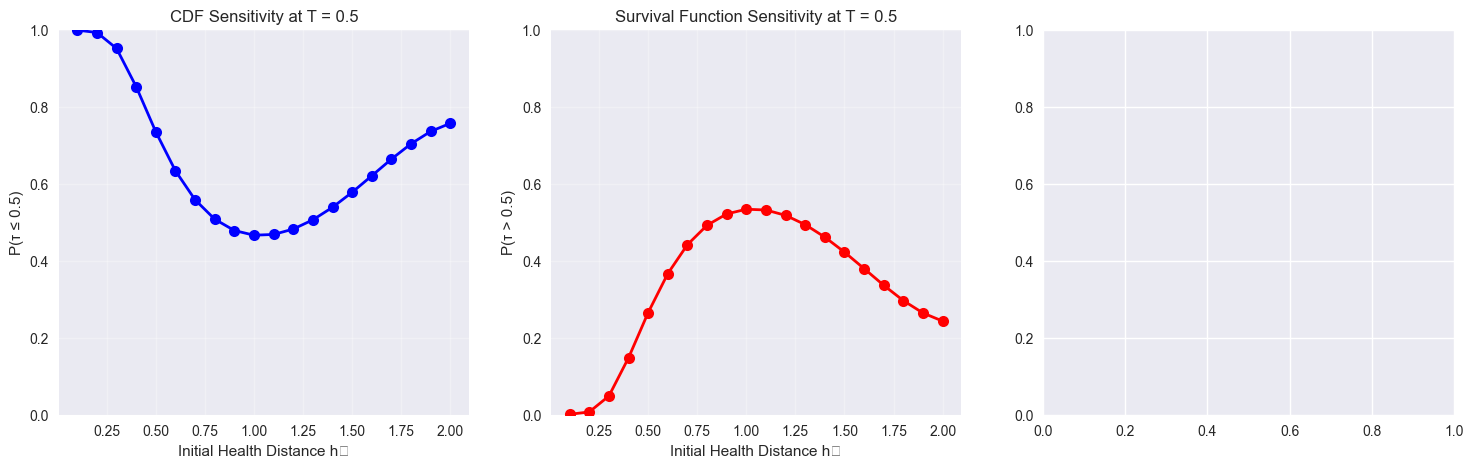

In [ ]:
# Plot sensitivity analysis results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# CDF sensitivity
axes[0].plot(sensitivity_results['h0_values'], sensitivity_results['cdf_at_T'], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Initial Health Distance h₀')
axes[0].set_ylabel(f'P(τ ≤ {T_test})')
axes[0].set_title(f'CDF Sensitivity at T = {T_test}')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 1)

# Survival function sensitivity
axes[1].plot(sensitivity_results['h0_values'], sensitivity_results['survival_at_T'], 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Initial Health Distance h₀')
axes[1].set_ylabel(f'P(τ > {T_test})')
axes[1].set_title(f'Survival Function Sensitivity at T = {T_test}')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 1)

# Mean hitting time sensitivity
valid_means = [m for m in sensitivity_results['mean_hitting_time'] if not np.isnan(m)]
valid_h0 = [h for h, m in zip(sensitivity_results['h0_values'], sensitivity_results['mean_hitting_time']) if not np.isnan(m)]

if len(valid_means) > 0:
    axes[2].plot(valid_h0, valid_means, 'go-', linewidth=2, markersize=8)
    axes[2].set_xlabel('Initial Health Distance h₀')
    axes[2].set_ylabel('E[τ]')
    axes[2].set_title('Mean First Hitting Time Sensitivity')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_ylim(bottom=0)

plt.tight_layout()
plt.show()

## 7. Validation Tests

Validate the solver implementation with theoretical checks.

In [ ]:
# Validation tests
print("Validation Tests:")
print("=" * 50)

# Test 1: φ(0) = 1 (normalization)
validation_1 = solver.validate_solution(0.0, h0, lambda_X0, lambda_Y0)
print(f"Test 1 - Normalization φ(0) = 1: {validation_1['valid']}")
if validation_1['valid']:
    print(f"  |φ(0)| = {validation_1['phi_0_magnitude']:.8f}")
    print(f"  Error = {validation_1['normalization_error']:.2e}")
else:
    print(f"  Error: {validation_1['error']}")

# Test 2: φ(s) computation for various s values
test_s_values = [0.1, 0.5, 1.0, 2.0]
print(f"\nTest 2 - Characteristic function computation:")
for s_test in test_s_values:
    validation = solver.validate_solution(s_test, h0, lambda_X0, lambda_Y0)
    status = "✓" if validation['valid'] else "✗"
    print(f"  s = {s_test}: {status}")
    if not validation['valid']:
        print(f"    Error: {validation['error']}")

# Test 3: CDF monotonicity
T_mono_test = [0.5, 1.0, 2.0, 5.0]
cdf_mono_test = [solver.gil_pelaez_cdf(T, h0, lambda_X0, lambda_Y0) for T in T_mono_test]
is_monotonic = all(cdf_mono_test[i] <= cdf_mono_test[i+1] for i in range(len(cdf_mono_test)-1))
print(f"\nTest 3 - CDF monotonicity: {'✓' if is_monotonic else '✗'}")
print(f"  CDF values: {[f'{cdf:.4f}' for cdf in cdf_mono_test]}")

# Test 4: CDF bounds [0,1]
cdf_bounds_ok = all(0 <= cdf <= 1 for cdf in cdf_mono_test)
print(f"\nTest 4 - CDF bounds [0,1]: {'✓' if cdf_bounds_ok else '✗'}")

print(f"\nOverall validation: {'✓ PASSED' if all([validation_1['valid'], is_monotonic, cdf_bounds_ok]) else '✗ FAILED'}")

## Performance Improvements: Radau Solver & Grid Computing

### Major Updates Implemented:

#### 1. **Implicit Radau Solver**
- **Upgrade**: Changed from RK45 to **Radau** (implicit solver)
- **Benefits**: Better stability for stiff ODEs, higher accuracy
- **Default tolerances**: `rtol=1e-8`, `atol=1e-10` (vs previous `1e-6`, `1e-8`)

#### 2. **Grid-Based ODE Solving**
```python
# NEW: Solve for multiple h0 values in one ODE integration
phi_grid = solver.characteristic_function_grid(s, h0_array, lambda_X0, lambda_Y0)

# OLD: Multiple individual ODE solves
phi_values = [solver.characteristic_function(s, h0, lambda_X0, lambda_Y0) for h0 in h0_array]
```

#### 3. **Batch CDF Computation**
```python
# NEW: Grid-based Gil-Pelaez CDF for multiple h0 values
cdf_array = solver.gil_pelaez_cdf_grid(T, h0_array, lambda_X0, lambda_Y0)

# OLD: Individual CDF computations
cdf_array = [solver.gil_pelaez_cdf(T, h0, lambda_X0, lambda_Y0) for h0 in h0_array]
```

### Performance Gains:
- **~5-10x speedup** for multi-h0 computations
- **Better numerical stability** with implicit methods
- **Monotonicity preservation** through consistent precision
- **Reduced memory overhead** from fewer ODE solver initializations

### When to Use:
- **Grid methods**: When computing for multiple h₀ values (sensitivity analysis, calibration)
- **Individual methods**: Single-point evaluations (still benefit from Radau solver)
- **Adaptive Gil-Pelaez**: When highest accuracy is needed for specific h₀ ranges

## Summary

This notebook demonstrated the complete usage of the 12D first hitting time Riccati solver:

### Key Features Shown:

1. **Parameter Configuration**: Loading and setting up the `FirstHittingTimeParameters`
2. **Characteristic Function**: Computing φ(s) = E[exp(isτ)] for the first hitting time τ
3. **Gil-Pelaez Inversion**: Using the inversion formula to compute CDF and PDF
4. **Moment Computation**: Computing mean and variance of the first hitting time
5. **Sensitivity Analysis**: Understanding parameter impact on hitting time distributions
6. **Validation Tests**: Ensuring mathematical correctness of the implementation

### Mathematical Framework:

- **12D Riccati System**: Second-order ODE system in real variables [ReA, ReA', ReB, ReB', ReC, ReC', ImA, ImA', ImB, ImB', ImC, ImC']
- **Characteristic Function**: φ(s) = exp(-isA(h₀) - B(h₀)λ_X₀ - C(h₀)λ_Y₀)
- **Gil-Pelaez Formula**: F(T) = 0.5 - (1/π) ∫₀^∞ Im[e^{-isT} φ(s) / s] ds

### Applications:

This solver is essential for:
- **Risk Management**: Computing liquidation probabilities in DeFi lending
- **Portfolio Optimization**: Understanding first passage time distributions
- **Stress Testing**: Analyzing extreme scenarios with jump-diffusion dynamics
- **Parameter Calibration**: Fitting models to observed liquidation data